In [54]:
import pandas as pd
import numpy as np

from pprint import pprint

import env

%matplotlib inline
import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

from sklearn.feature_extraction.text import CountVectorizer


import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score

In [2]:
# our string to test
document = 'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

In [3]:
# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
a,3,0.272727,1.000000
little,3,0.272727,1.000000
lamb,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


In [4]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': "codeup's data science program wa created in response to a "
            'percieved lack of data science talent and growing demand',
 'description': "codeup's data science program teach hand on skill using "
                'python and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


In [5]:
# Then we can calculate the inverse document frequency metric for each word.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences


In [6]:
# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

In [7]:
# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
.head())

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


In [10]:
tfs = []


In [11]:
# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)


In [12]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)).pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x)).fillna(0)

word,18,a,and,announced,codeup,codeup's,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


# TF-IDF with scikit-learn



In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [14]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,18,and,announced,codeup,created,data,demand,growing,hand,in,...,skill,talent,teach,that,they,thursday,to,using,wa,week
0,0.263566,0.000000,0.263566,0.155666,0.000000,0.155666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.263566,0.263566,0.263566,0.000000,0.000000,0.000000,0.263566
1,0.000000,0.253880,0.000000,0.197160,0.000000,0.197160,0.000000,0.000000,0.333821,0.000000,...,0.333821,0.000000,0.333821,0.000000,0.000000,0.000000,0.000000,0.333821,0.000000,0.000000
2,0.000000,0.195932,0.000000,0.152159,0.257627,0.304317,0.257627,0.257627,0.000000,0.257627,...,0.000000,0.257627,0.000000,0.000000,0.000000,0.000000,0.257627,0.000000,0.257627,0.000000


In [15]:
def get_db_url(database, host=env.host, user=env.username, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [16]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# TFIDF

In [17]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [18]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train) 
X_test = tfidf.transform(X_test)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# Logistic Reg / TF- IDF

In [19]:
lm = LogisticRegression().fit(X_train, y_train)
 
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [20]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))


Accuracy: 97.53%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   108
spam          2   490
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
labels = ['true', 'false']

In [23]:
cm = confusion_matrix(train.actual, train.predicted)

In [24]:
cm

array([[3857,    2],
       [ 108,  490]])

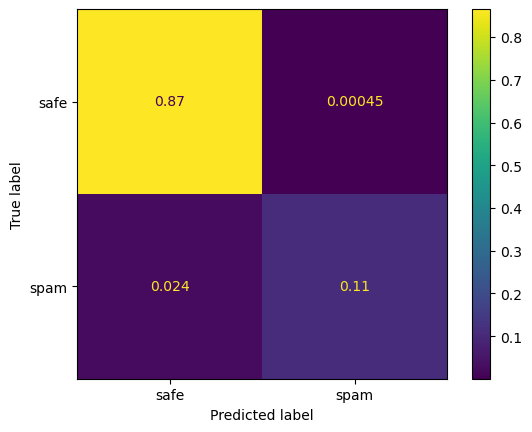

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train.actual, train.predicted, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['safe','spam'])
cmd.plot()

# LOG REG / Bag of words

In [ ]:
# object instance
cv = CountVectorizer()

# fit and transform
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)


In [87]:
lm = LogisticRegression().fit(X_train, y_train)
 
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [88]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 99.82%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3859     8
spam          0   590
---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      0.99      0.99       598

    accuracy                           1.00      4457
   macro avg       1.00      0.99      1.00      4457
weighted avg       1.00      1.00      1.00      4457



<div class="alert alert-block alert-info">
# bag of words worked best for log reg

# Exercise


The lesson shows regression but we could use `decision tree`, `random forest`, `xgboost` variations


# Decision Tree / TF-IDF

In [26]:
# create obj
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
   

In [27]:
# fit
clf.fit(X_train, y_train)
    

DecisionTreeClassifier(max_depth=4, random_state=42)

<4457x7709 sparse matrix of type '<class 'numpy.float64'>'
	with 59259 stored elements in Compressed Sparse Row format>

In [35]:
# Accuracy and Recall for the test data
test['dec_preds'] = clf.predict(X_test)

In [48]:
# Accuracy and Recall for the test data
test_accuracy = accuracy_score(test['actual'], test['dec_preds'])


In [51]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.dec_preds)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.dec_preds, test.actual))
print('---') 
print(classification_report(test.actual, test.dec_preds)) 




Accuracy: 94.71%
---
Confusion Matrix
actual     ham  spam
dec_preds           
ham        949    42
spam        17   107
---
              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       966
        spam       0.86      0.72      0.78       149

    accuracy                           0.95      1115
   macro avg       0.91      0.85      0.88      1115
weighted avg       0.94      0.95      0.95      1115



# Decision Tree / bag of words

In [82]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [83]:
# object instance
cv = CountVectorizer()

# fit and transform
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)


In [84]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [85]:
# create obj
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# fit
clf.fit(X_train, y_train)
    
# Accuracy and Recall for the test data
test['dec_preds'] = clf.predict(X_test)
   
# Accuracy and Recall for the test data
test_accuracy = accuracy_score(test['actual'], test['dec_preds'])  

In [86]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.dec_preds)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.dec_preds, test.actual))
print('---') 
print(classification_report(test.actual, test.dec_preds)) 




Accuracy: 93.72%
---
Confusion Matrix
actual     ham  spam
dec_preds           
ham        946    50
spam        20    99
---
              precision    recall  f1-score   support

         ham       0.95      0.98      0.96       966
        spam       0.83      0.66      0.74       149

    accuracy                           0.94      1115
   macro avg       0.89      0.82      0.85      1115
weighted avg       0.93      0.94      0.93      1115



# how do the models compare when train on term freq

<div class="alert alert-block alert-info">
# Decision Tree had better performacnce with TF-IDF